# All Noise No Signal: SGD is Asymptotically Brownian

[Previously, I made the claim that singularities translate random motion at the bottom of loss basins into search for generalization](https://www.lesswrong.com/posts/2N7eEKDuL5sHQou3N/spooky-action-at-a-distance-in-the-loss-landscape). Complex singularities corresponding to simple functions "trap" the random motion, and these simple functions generalize better.

Let's put that claim to the test. 

In particular, can we make models with low training error but high test error generalize simply by exploring the set of low loss points? In particular, if you take a pre-grokked model, can you make it grok via Hamiltonian MC once it's reached a minimum loss point?

Here's the proposal: given a starting choice of weights $\mathbf w \in \mathbb R^d$, explore the nearby space using Hamiltonian MC (or something fancier like NUTS). That is:
1. Sample a momentum $\mathbf p \sim \mathcal N(0, \boldsymbol I_{d\times d})$.
2. Evolve according to the equations of motion, where we treat the loss over either (1) a batch or (2) the entire test set as the energy.
3. Compare to the model obtained by training normally (via minibatch SGD/full-batch GD) in terms of test loss.  

If my hypothesis is right, then we should expect the model to become more general even when we're no longer explicitly optimizing it (for better training loss / lower weight norms).


Thanks to [Marius Hobbhahn](https://www.lesswrong.com/users/marius-hobbhahn) and [Neel Nanda](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20) for their grokking code.

In [ ]:
!nvidia-smi
!pip install einops 

Tue Feb  7 21:35:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set-up

## Imports

In [ ]:
import random
import time
from pathlib import Path
import pickle
import os
import copy
from collections import OrderedDict
import functools
import itertools
import gc

import numpy as np
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd

# pio.renderers.default = "colab"
%matplotlib inline

## Hyperparameters

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
lr=1e-3 #@param
weight_decay = 0.1 #@param 
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.3 #@param
NUM_EPOCHS = 100000 #@param
save_models = False #@param
save_every = 1000 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param
seed = 0 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1 
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
#batch_size = BATCH_SIZE

## Architecture

In [ ]:
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)


class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]


class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x


class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        
    def forward(self, x):
        k = torch.einsum('ihd,bpd->biph', self.W_K, x)
        q = torch.einsum('ihd,bpd->biph', self.W_Q, x)
        v = torch.einsum('ihd,bpd->biph', self.W_V, x)
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = F.softmax(attn_scores_masked/np.sqrt(self.d_head), dim=-1)
        z = torch.einsum('biph,biqp->biqh', v, attn_matrix)
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out


class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in
        
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x


class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
    
    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.mlp((x))
        return x


class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_ln=True):
        super().__init__()

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x


In [ ]:
def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch  
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

In [ ]:
## set torch seed 
SEED = 0
torch.manual_seed(SEED)

# Data

As described in Neel's post, every input sequence is of the form `(i, j, num)` where the target is `i+j mod num`

In [ ]:
def gen_train_test(frac_train = 0.3, num = 113, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train_x, test_x = gen_train_test(frac_train, 113, seed=0)
print(len(train_x), len(test_x))

print(train_x[:10])
print(test_x[:10])

3830 8939
[(18, 34, 113), (10, 83, 113), (55, 28, 113), (25, 51, 113), (63, 65, 113), (14, 104, 113), (27, 56, 113), (35, 77, 113), (41, 72, 113), (17, 111, 113)]
[(50, 67, 113), (92, 107, 113), (29, 14, 113), (76, 53, 113), (78, 80, 113), (77, 58, 113), (97, 1, 113), (39, 59, 113), (95, 73, 113), (38, 40, 113)]


In [ ]:
### create training and test samples in batches

def collate_batch(batch):
    label_list = [(i+j) % num for (i,j,num) in batch]
    label_list = torch.tensor(label_list, dtype=torch.int64)
    input_list = [torch.tensor(x) for x in batch]
    input_list = torch.cat(input_list).view(len(label_list), -1)
    return input_list.to(DEVICE), label_list.to(DEVICE)

# one batch per loader
train_loader = DataLoader(train_x, batch_size=len(train_x), collate_fn=collate_batch)
test_loader = DataLoader(test_x, batch_size=len(test_x), collate_fn=collate_batch)

print(len(train_loader))
for x, y in train_loader:
    print(x[:10])
    print(y[:10])

1
tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]], device='cuda:0')
tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')


In [ ]:
def loss_of_final_number(logits, labels):
    # only look at predictions of last numbers
    logits = logits[:,-1]
    # compute individual and summed losses for final number
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels.unsqueeze(1), dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

# Training

In [ ]:
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, 
                    d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_ln=False).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))

In [ ]:
# train
train_losses = []
test_losses = []
train_accs = []
test_accs = []

weights_epochs = {}
grads_epochs = {}

for i in trange(NUM_EPOCHS, desc="Epoch"):
    final_digit_loss = 0
    for j, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        train_loss = loss_of_final_number(out, y)
        sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
        correct = (y == sm_argmax.view(-1)).detach()

        train_loss.backward()
        optimizer.step()

        final_digit_loss += train_loss.item()

    train_losses.append(final_digit_loss)
    train_accs.append(correct.float().mean().item())

    if i % save_every == 0:
        print("epoch {}; training loss {};".format(i, final_digit_loss))
        print("training acc {};".format(correct.float().mean()))
        # run a test every N iterations
        for x, y in test_loader:

            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            test_loss = loss_of_final_number(out, y)
            sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
            correct = (y == sm_argmax.view(-1)).detach()

        print("test loss: {}".format(test_loss.item()))
        print("test acc: {}".format(correct.float().mean()))
        test_losses.append(test_loss.item())
        test_accs.append(correct.float().mean().item())

        print("\n")

        # store the weights
        weights_epochs["weights_epoch_{}".format(i)] = copy.deepcopy(model.state_dict())

        # get and store gradients
        gradient_dict = OrderedDict()
        for name, param in model.named_parameters():
            gradient_dict["grad_{}".format(name)] = copy.deepcopy(param.grad)

        grads_epochs["grads_epoch_{}".format(i)] = gradient_dict


Epoch:   0%|          | 0/100000 [00:00<?, ?it/s]

epoch 0; training loss 4.773175904538197;
training acc 0.007832897827029228;
test loss: 4.750791208233164
test acc: 0.007942723110318184




KeyboardInterrupt: ignored

In [ ]:
## did it learn the training dist?
for x, y in train_loader:
    out = model(x.to(DEVICE))
    sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:10, -1].detach()
    input = x[:10, :]
    print(x.size())
    print("input: ", input)
    label = y[:10]
    print("label: ", label[:10])
    print("argmax prediction: ", sm_argmax)
    print("same: ", label[:10] == sm_argmax)
    break

torch.Size([3830, 3])
input:  tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]], device='cuda:0')
label:  tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')
argmax prediction:  tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')
same:  tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')


In [ ]:
## test stuff

for x, y in test_loader:
    out = model(x.to(DEVICE))
    sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:10, -1].detach()
    input = x[:10, :]
    print(x.size())
    print("input: ", input)
    label = y[:10]
    print("label: ", label[:10])
    print("argmax prediction: ", sm_argmax)
    print("same: ", label[:10] == sm_argmax)
    break

torch.Size([8939, 3])
input:  tensor([[ 50,  67, 113],
        [ 92, 107, 113],
        [ 29,  14, 113],
        [ 76,  53, 113],
        [ 78,  80, 113],
        [ 77,  58, 113],
        [ 97,   1, 113],
        [ 39,  59, 113],
        [ 95,  73, 113],
        [ 38,  40, 113]], device='cuda:0')
label:  tensor([ 4, 86, 43, 16, 45, 22, 98, 98, 55, 78], device='cuda:0')
argmax prediction:  tensor([ 4, 86, 43, 16, 45, 22, 98, 98, 55, 78], device='cuda:0')
same:  tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')


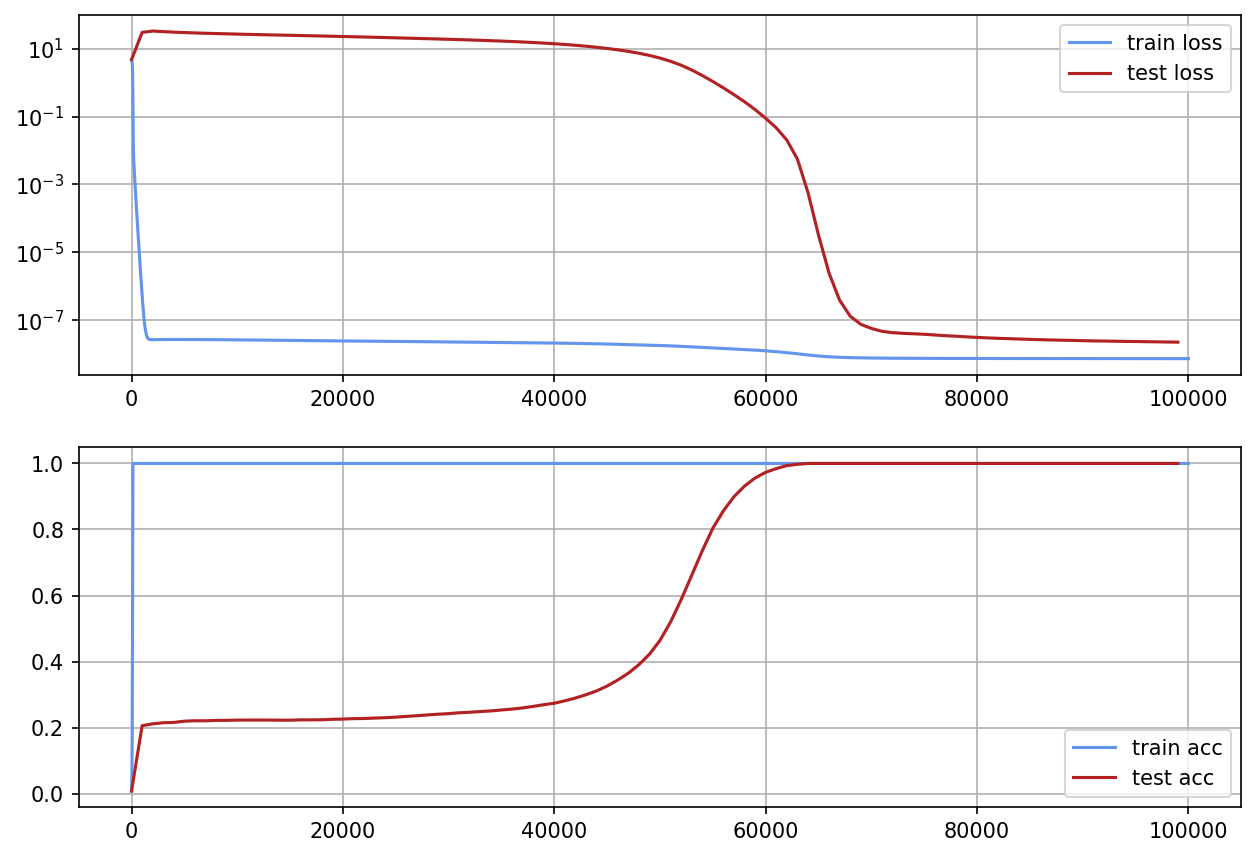

In [ ]:
## plot the training and test loss
x_train = np.arange(len(train_losses)) 
x_test = np.arange(len(test_losses)) * save_every
 
fig, ax = plt.subplots(2,1,figsize=(10, 7), dpi=150)

ax[0].grid()
ax[0].plot(x_train, train_losses, color="cornflowerblue", label="train loss")
ax[0].plot(x_test, test_losses, color="firebrick", label="test loss")
ax[0].legend()
ax[0].set_yscale("log")

ax[1].grid()
ax[1].plot(x_train, train_accs, color="cornflowerblue", label="train acc")
ax[1].plot(x_test, test_accs, color="firebrick", label="test acc")
ax[1].legend()

plt.show()

# Let's inject some noise

At this point, the model has excellent training loss, but terrible test loss. 

Let's continue with four variants:
1. Train with Adam but no weight decay
2. Train with Adam and weight decay
3. Hamiltonian MC with no weight decay
4. Hamiltonian MC with weight decay

In [ ]:
# Save a checkpoint
from google.colab import drive
drive.mount('/content/gdrive')

# checkpoint = model.state_dict()
path = Path("/content/gdrive/My Drive/AI/grokking-checkpoints.pt")
# path.parent.mkdir(parents=True, exist_ok=True)
# torch.save(weights_epochs, path)    

Mounted at /content/gdrive


In [ ]:
weights_epochs = torch.load(path)

In [ ]:
from typing import Optional, Union, Tuple


class MC(optim.Optimizer):
    def __init__(
        self, 
        params, 
        lr=1e-3, 
        weight_decay: Union[float, Tuple[float, float]] = 0., 
        beta=None, 
        mass=1., 
        start_energy: Optional[torch.Tensor] = None, 
        device="cpu"
    ) -> None:
        if not isinstance(weight_decay, tuple):
          weight_decay = (weight_decay, weight_decay)  # The first argument is for computing energy, the second for dynamics

        super().__init__(params, dict(lr=lr, weight_decay=weight_decay, beta=beta, mass=mass))

        self.device = device
        self.hyperparams = dict(lr=lr, weight_decay=weight_decay, beta=beta, mass=mass)
        self.params = self.param_groups[0]['params']
        self.n_params = sum((p.numel() for p in self.params))

        self.start = self.new_start()
        self.start_energy = start_energy

    def mh_check(self, loss: torch.Tensor):
        # Metropolis-Hasting acceptance step to account for numerical error + approximation over minibatch
        new_energy = self.to_energy(loss)
        is_accepted = torch.rand(1).to(self.device) < torch.exp((self.start_energy - new_energy) * self.hyperparams['beta'])
        
        # print(self.start_energy, new_energy, (self.start_energy - new_energy) * self.hyperparams['beta'], is_accepted)
        if is_accepted:
            self.new_start_()
            self.start_energy = new_energy
            self.momentum = self.sample_momentum()
        else:
            self.restart_()

        return is_accepted

    def to_energy(self, loss: torch.Tensor):
        return loss.clone().detach().to(self.device) + self.regularization()

    def to_beta(self, energy: torch.Tensor):
        # Equipartition theorem
        # Number of degrees of freedom = 2 * self.n_params (because of momentum)
        return self.n_params / energy  

    def regularization(self):
        # Q: Should I include this in the energy term? Or not?
        value = torch.zeros(1, device=self.device)

        for w in self.params:
            value += 0.5 * self.hyperparams['weight_decay'][0] * w.data.norm() ** 2

        return value

    def new_start(self):
        return tuple((
            w.data.clone().detach().to(self.device)
            for w in self.params
        ))

    def new_start_(self):
        """Start a new trajectory at the current params"""
        for w, start in zip(self.params, self.start):
            start.data = w.data.clone().to(self.device)
    
    def restart_(self):
        """Restart the current params to the start of the current trajectory"""
        for w, start in zip(self.params, self.start):
            w.data = start.data.clone().to(self.device)

class HMC(MC):
    """
    HMC works as follows:

    1. At an initial timestep, you sample a random momentum from a normal distribution.
    2. You treat the system as a physical system describing a particle and evolve
       it according to the equations of motion given by the function/distribution 
       you're exploring along with the momentum you sampled. 
    3. After some number of timesteps L, you include a Metropolis-Hastings step
       to correct for any numerical error that might have accumulated.

    Usually, you evolve with the leapfrogging algorithm, which reduces the amount
    of error that accumulates (at the cost of some extra compute).

    Here, I'm also approximating the value of the loss (the function 
    we're approximating) over minibatches, and I believe this error will dominate
    any numerical error, so I've left out leapfrogging for noisier Euler-Maryuama integration.  

    Currently the MH check has to be manually invoked. I'm running it at the end
    of each epoch. 

    """

    def __init__(
        self, 
        params, 
        lr=1e-3, 
        weight_decay: Union[float, Tuple[float, float]] = 0., 
        beta=None, 
        mass=1., 
        start_energy: Optional[torch.Tensor] = None, 
        device="cpu"
    ) -> None:
        """
        Leave beta (the inverse temperature) undefined for it to be defined adaptively based on the first sample you give it.
        From the provided starting energy, it'll compute the associated characteristic temperature and use that.

        """
        super().__init__(params, lr, weight_decay, beta, mass, start_energy, device)
        self.momentum = self.sample_momentum()

    def step(self, loss: torch.Tensor):
        # TODO: Consider leapfrogging (my guess is that most of the error comes from the minibatch approximation)
        
        if self.start_energy is None:
            self.start_energy = self.to_energy(loss)
            
        if self.hyperparams["beta"] is None:
            self.hyperparams["beta"] = self.to_beta(self.start_energy)
        
        for p, w in zip(self.momentum, self.params):
            # H(w, p) = Loss(w) + \lambda|w|^2 + (1/(2m))|p|^2
            # dw/dt = \partial_p H = p/m
            dw_dt = (p / self.hyperparams['mass'])
            # dp/dt = -\partial_w H = -\partial_w Loss(w) - \lambda w 
            dp_dt = - (w.grad + self.hyperparams['weight_decay'][1] * w.data)

            w.data.add_(self.hyperparams['lr'] * dw_dt)
            p.data.add_(self.hyperparams['lr'] * dp_dt)
        
    def sample_momentum(self):
        """Sample a new momentum vector from a standard normal distribution with variance beta"""
        return tuple(
            torch.randn(p.shape).to(self.device) 
            for p in self.params  
        )

    def sample_momentum_(self):
        for p in self.momentum:
            p.data = torch.randn(p.shape)

In [ ]:
class AdamOnSphere(optim.Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=(0., 1e-2),
        amsgrad=False,
        *,
        maximize: bool = False,
        foreach: Optional[bool] = None,
        capturable: bool = False,
        differentiable: bool = False,
        fused: Optional[bool] = None,
    ):
        """
        Weight decay is no provided as a tuple where the first value is the desired 
        "equilibrium" norm (i.e., the norm that would give weight decay zero), and 
        the second value is the curvature of the weight decay.
        """
        if not 0.0 <= weight_decay[0] or not 0.0 <= weight_decay[1]:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        self.weight_decay = weight_decay

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            amsgrad=amsgrad,
            foreach=foreach,
            maximize=maximize,
            capturable=capturable,
            differentiable=differentiable,
            fused=fused,
        )
        params = tuple(params)

        self.adam = optim.Adam(params, **defaults)

        defaults["weight_decay"] = weight_decay
        super().__init__(params, defaults)

        self.params = params
        self.n_params = sum((p.numel() for p in self.params))

    def step(self):
        self.adam.step()

        for p in self.params:
            p.data += self.defaults["lr"] * self.defaults["weight_decay"][1] * (p.data - self.defaults["weight_decay"][0] * p.numel() / self.n_params)

class RepulsiveAdam(optim.Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_repulsion=1e-2,
        amsgrad=False,
        *,
        maximize: bool = False,
        foreach: Optional[bool] = None,
        capturable: bool = False,
        differentiable: bool = False,
        fused: Optional[bool] = None,
    ):
        """
        Weight decay is no provided as a tuple where the first value is the desired 
        "equilibrium" norm (i.e., the norm that would give weight decay zero), and 
        the second value is the curvature of the weight decay.
        """
        if not 0.0 <= weight_repulsion:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        self.weight_repulsion = weight_repulsion

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            amsgrad=amsgrad,
            foreach=foreach,
            maximize=maximize,
            capturable=capturable,
            differentiable=differentiable,
            fused=fused,
        )
        params = tuple(params)

        self.adam = optim.Adam(params, **defaults)

        defaults["weight_repulsion"] = weight_repulsion
        super().__init__(params, defaults)

        self.params = params
        self.init_params = tuple((p.detach().clone().to(DEVICE) for p in self.params))
        self.n_params = sum((p.numel() for p in self.params))

    def step(self):
        self.adam.step()

        for p, p0 in zip(self.params, self.init_params):
            # L1 norm \lambda * |w-w_0| => update: \lambda * sign(w-w_0)
            dw_sign = torch.sign(p.data - p0.data)
            # TODO: Do something with the 0s
            p.data += self.defaults["lr"] * self.defaults["weight_repulsion"] * dw_sign


class NoisyAdam(optim.Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        noise=1e-2,
        amsgrad=False,
        *,
        maximize: bool = False,
        foreach: Optional[bool] = None,
        capturable: bool = False,
        differentiable: bool = False,
        fused: Optional[bool] = None,
    ):
        """
        Weight decay is no provided as a tuple where the first value is the desired 
        "equilibrium" norm (i.e., the norm that would give weight decay zero), and 
        the second value is the curvature of the weight decay.
        """
        if not 0.0 <= noise:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        self.noise = noise

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            amsgrad=amsgrad,
            foreach=foreach,
            maximize=maximize,
            capturable=capturable,
            differentiable=differentiable,
            fused=fused,
        )
        params = tuple(params)

        self.adam = optim.Adam(params, **defaults)

        defaults["noise"] = noise
        super().__init__(params, defaults)

        self.params = params
        self.init_params = tuple((p.detach().clone().to(DEVICE) for p in self.params))
        self.n_params = sum((p.numel() for p in self.params))

    def step(self):
        self.adam.step()

        for p, p0 in zip(self.params, self.init_params):
            p.data += self.defaults["lr"] * self.noise * p.data.norm() * torch.randn(p.data.shape, device=DEVICE)
   

In [ ]:
# print(weights_epochs.keys())
# checkpoint = weights_epochs["weights_epoch_0"]

# Make the variants
kwargs = dict(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp,
              d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_ln=False)

model = Transformer(**kwargs)
# model.load_state_dict(checkpoint)

def make_variation(name: str, model: nn.Module, opt_cls: optim.Optimizer = optim.AdamW, *args, **kwargs):
    adam_model = copy.deepcopy(model)
    optimizer = opt_cls(adam_model.parameters(), *args, **kwargs)

    return (name, adam_model, optimizer)

hmc_lr = 0.001
hmc_mass = 1000
min_energy = 1e-5
wds = [0, 0.0001, 0.001, 0.01, 0.1, 1]
MH_IVL = 25

variations = [
    # make_variation("Adam", model, lr=lr, weight_decay=0, betas=(0.9, 0.98)),
    # make_variation("Adam_WD_1", model, lr=lr, weight_decay=0.0001, betas=(0.9, 0.98)),
    # make_variation("Adam_WD_2", model, lr=lr, weight_decay=0.001, betas=(0.9, 0.98)),
    # make_variation("Adam_WD_3", model, lr=lr, weight_decay=0.01, betas=(0.9, 0.98)),
    make_variation("Adam_WD_4", model, lr=lr, weight_decay=0.1, betas=(0.9, 0.98)),
    make_variation("Adam_WD_5", model, lr=lr, weight_decay=0.3, betas=(0.9, 0.98)),
    make_variation("Adam_WD_6", model, lr=lr, weight_decay=0.5, betas=(0.9, 0.98)),
    make_variation("Adam_WD_7", model, lr=lr, weight_decay=1, betas=(0.9, 0.98)),

    # Adam weird
    # make_variation("AdamSphere_0", model, opt_cls=AdamOnSphere, lr=lr, weight_decay=(2, 1e-2), betas=(0., 0.)),
    # make_variation("AdamSphere_1", model, opt_cls=AdamOnSphere, lr=lr, weight_decay=(1, 1e-2), betas=(0., 0.)),
    # make_variation("AdamSphere_2", model, opt_cls=AdamOnSphere, lr=lr, weight_decay=(50, 1e-2), betas=(0., 0.)),

    # make_variation("AdamRepulsive_1", model, opt_cls=RepulsiveAdam, lr=lr, weight_repulsion=0.01, betas=(0., 0.)),
    # make_variation("AdamRepulsive_0", model, opt_cls=RepulsiveAdam, lr=lr, weight_repulsion=0.001, betas=(0., 0.)),
    # make_variation("AdamSphere_2", model, opt_cls=RepulsiveAdam, lr=lr, weight_repulsion=0.0001, betas=(0.9, 0.98)),

    # Adam noise
    # make_variation("AdamNoise_1", model, opt_cls=NoisyAdam, lr=lr, noise=0.00001, betas=(0., 0.)),
    # make_variation("AdamNoise_1", model, opt_cls=NoisyAdam, lr=lr, noise=0.0001, betas=(0., 0.)),
    # make_variation("AdamNoise_2", model, opt_cls=NoisyAdam, lr=lr, noise=0.001, betas=(0., 0.)),
    # make_variation("AdamNoise_3", model, opt_cls=NoisyAdam, lr=lr, noise=0.01, betas=(0., 0.)),
    # make_variation("AdamNoise_4", model, opt_cls=NoisyAdam, lr=lr, noise=0.1, betas=(0., 0.)),
    # make_variation("AdamNoise_5", model, opt_cls=NoisyAdam, lr=lr, noise=1, betas=(0., 0.)),

    # HMCs
    # make_hmc_variation("HMC_0", model, lr=hmc_lr, weight_decay=0, mass=hmc_mass, start_energy=min_energy, device=DEVICE),
    # make_hmc_variation("HMC_WD_1", model, lr=hmc_lr, weight_decay=0.0001, mass=hmc_mass, device=DEVICE),
    # make_hmc_variation("HMC_WD_2", model, lr=hmc_lr, weight_decay=0.001, mass=hmc_mass, device=DEVICE),     
    # make_hmc_variation("HMC_WD_3", model, lr=hmc_lr, weight_decay=0.01, mass=hmc_mass, device=DEVICE),     
    # make_hmc_variation("HMC_WD_4", model, lr=hmc_lr, weight_decay=5, mass=hmc_mass, device=DEVICE),     
    # make_hmc_variation("HMC_WD_5", model, lr=hmc_lr, weight_decay=10,  mass=hmc_mass, device=DEVICE),
    # make_hmc_variation("HMC_WD_6", model, lr=hmc_lr, weight_decay=50,  mass=hmc_mass, device=DEVICE),  
    # make_hmc_variation("HMC_WD_7", model, lr=hmc_lr, weight_decay=100,  mass=hmc_mass, device=DEVICE),  
    # make_hmc_variation("HMC_WD_1b", model, lr=hmc_lr, weight_decay=(0, 0.0001), mass=hmc_mass, start_energy=min_energy, device=DEVICE),
    # make_hmc_variation("HMC_WD_2b", model, lr=hmc_lr, weight_decay=(0, 0.001), mass=hmc_mass, start_energy=min_energy, device=DEVICE),     
    # make_hmc_variation("HMC_WD_3b", model, lr=hmc_lr, weight_decay=(0, 0.01), mass=hmc_mass, start_energy=min_energy, device=DEVICE),     
    # make_hmc_variation("HMC_WD_4b", model, lr=hmc_lr, weight_decay=(0, 5), mass=hmc_mass, start_energy=min_energy, device=DEVICE),      
    # make_hmc_variation("HMC_WD_5b", model, lr=hmc_lr, weight_decay=(0, 10), mass=hmc_mass, start_energy=min_energy, device=DEVICE),      
    # make_hmc_variation("HMC_WD_6b", model, lr=hmc_lr, weight_decay=(0, 50),  mass=hmc_mass, device=DEVICE),  
    # make_hmc_variation("HMC_WD_7b", modeal, lr=hmc_lr, weight_decay=(0, 100),  mass=hmc_mass, device=DEVICE),  
]

# Can probably define all three cleverly with zip & unpacking
model_names = [
    variation[0] for variation in variations
]

models = [
    variation[1] for variation in variations
]

optimizers = [
    variation[2] for variation in variations
]

hmc_variations = [variation for variation in variations if isinstance(variation[2], HMC)]

init_parameters = [[p.clone().detach().to(DEVICE) for p in model.parameters()] for model in models]

from pprint import pp
print(model_names)
# print(optimizers[3].n_params)


['Adam_WD_4', 'Adam_WD_5', 'Adam_WD_6', 'Adam_WD_7']


In [ ]:
n_epochs = 60000
save_every = 500

# train
_df_full = [
    {"model": name, "epoch": i * save_every, "L_train": 0, "acc_train": 0, "L_train_with_wd": 0, "L_test": 0, "acc_test": 0, "L_test_with_wd": 0, "wd": 0, "d_from_init": 0}
    for i in range(n_epochs // save_every)
    for name, model in zip(model_names, models)
]

_df_min = [
    {"model": name, "epoch": i, "L_train": 0, "acc_train": 0}
    for i in range(n_epochs)
    for name, model in zip(model_names, models)
]

df_full = pd.DataFrame(_df_full)
df_min = pd.DataFrame(_df_min)

In [ ]:
for model in models:
  model.to(DEVICE)

def wd(model: nn.Module, weight_decay=weight_decay):
    return weight_decay * (sum((p.norm() ** 2) for p in model.parameters()).item())

train_losses = torch.zeros((len(models),), device=DEVICE)
train_corrects = torch.zeros((len(models),), device=DEVICE)

accepted_epochs = torch.zeros((len(hmc_variations), ), device=DEVICE)

for i in trange(n_epochs, desc="Epoch"):
    train_losses *= 0
    train_corrects *= 0

    for j, (x, y) in enumerate(train_loader):
        for k, (model, opt) in enumerate(zip(models, optimizers)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            out = model(x)
            batch_loss = loss_of_final_number(out, y)
            sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
            
            batch_loss.backward()

            if not isinstance(opt, HMC):
                # batch_loss.backward()
                opt.step()
                # opt.zero_grad()
            else:
                opt.step(batch_loss)

            opt.zero_grad()

            train_corrects[k] += (y == sm_argmax.view(-1)).sum()
            train_losses[k] += batch_loss

    # for k, (model, opt) in enumerate(zip(models, optimizers)):
    #     if isinstance(opt, HMC):
    #          train_losses[k].backward()
    #          opt.step(batch_loss)
    #
    #          opt.zero_grad()

    # Metropolis-Hastings checks
    if i % MH_IVL == 0:
        J = 0
        for j, optimizer in enumerate(optimizers):
            if isinstance(optimizer, HMC):
                accepted_epochs[J] += float(optimizers[j].mh_check(torch.tensor(train_losses[j])))
                J += 1
      

    for k, model in enumerate(models):
        df_min.loc[i * len(models) + k, "L_train"] = train_losses[k].item() / len(train_loader)
        df_min.loc[i * len(models) + k, "acc_train"] = train_corrects[k].item() / len(train_loader)

    if i % save_every == 0:
        I = (i // save_every)
        
        test_losses = np.zeros(len(models))
        test_corrects = np.zeros(len(models))

        # run a test every N iterations
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            for k, model in enumerate(models):
                out = model(x)
                sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
                
                test_losses[k] += loss_of_final_number(out, y).item()
                test_corrects[k] += (y == sm_argmax.view(-1)).sum().detach().item()
        
        for k, (model, init_params) in enumerate(zip(models, init_parameters)):
            df_full.loc[I * len(models) + k, "L_train"] = train_losses[k].item() / len(train_loader)
            df_full.loc[I * len(models) + k, "acc_train"] = train_corrects[k].item() / len(train_loader)
            df_full.loc[I * len(models) + k, "L_test"] = test_losses[k] / len(test_loader)
            df_full.loc[I * len(models) + k, "acc_test"] = test_corrects[k] / len(test_loader)
            df_full.loc[I * len(models) + k, "wd"] = wd(model)
            df_full.loc[I * len(models) + k, "L_train_with_wd"] = df_full.loc[I * len(models) + k, "L_train"] + df_full.loc[I * len(models) + k, "wd"]
            df_full.loc[I * len(models) + k, "L_test_with_wd"] = df_full.loc[I * len(models) + k, "L_test"] + df_full.loc[I * len(models) + k, "wd"]

            distance = torch.zeros(1, device=DEVICE)

            for p1, p2 in zip(model.parameters(), init_params):
                distance += torch.norm(p1-p2) ** 2

            distance = distance ** 0.5

            df_full.loc[I * len(models) + k, "d_from_init"] = distance.item()

        print(f"Epoch {i}")
        print("# accepted epochs: ", accepted_epochs * MH_IVL * 100 / i)
        print(df_full.loc[I * len(models): (I + 1) * len(models) - 1, ["model", "L_train", "acc_train", "L_test", "acc_test", "wd", "d_from_init"]])

        # Plot the metrics for all the epochs so far (compare models on same plots)
        # L_train next to L_loss; acc_train next to acc_test; L_train_with_wd next to L_test_with_wd; wd (2x width)

        # fig, axes = plt.subplots(4, 2, figsize=(12, 12))
        # axes_flattened = [ax for axes_row in axes for ax in axes_row]

        # for ax, metric in zip(axes_flattened, ["L_train", "L_test", "acc_train", "acc_test", "L_train_with_wd", "L_test_with_wd", "wd"]):
        #     for name, model in zip(model_names, models):
        #         model_data = df_full.copy().loc[df_full.model == name].loc[df_full.epoch <= I]
        #         xs = model_data.epoch * save_every
        #         ys = model_data[metric]
        #         ax.plot(xs, ys, label=name)
            
        #     ax.set_title(metric)
        #     ax.legend()

        # fig.show()



Epoch:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 0
# accepted epochs:  tensor([], device='cuda:0')
       model   L_train  acc_train    L_test  acc_test          wd  d_from_init
0  Adam_WD_4  4.776053         38  4.751249        74  177.712720     0.451713
1  Adam_WD_5  4.776053         38  4.751224        74  177.641626     0.452022
2  Adam_WD_6  4.776053         38  4.751198        74  177.570544     0.452488
3  Adam_WD_7  4.776053         38  4.751135        74  177.392932     0.454336
Epoch 500
# accepted epochs:  tensor([], device='cuda:0')
       model   L_train  acc_train     L_test  acc_test          wd  \
4  Adam_WD_4  0.000137       3830  27.675223       102  450.997852   
5  Adam_WD_5  0.000256       3830  24.658319       116  423.298535   
6  Adam_WD_6  0.000388       3830  22.709727       119  401.759766   
7  Adam_WD_7  0.000810       3830  19.834133       112  365.234473   

   d_from_init  
4    41.676407  
5    41.508633  
6    41.742664  
7    43.255466  
Epoch 1000
# accepted epochs:  tensor([], device='cuda:

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
# df_full = df_full.loc[df_full.epoch < 3000]
df_full["acc_test"] = df_full["acc_test"] / 8939

NameError: ignored

In [ ]:
ax = df_full.plot("epoch", "L_test")
ax.set_xscale("log")
ax.set_yscale("log")


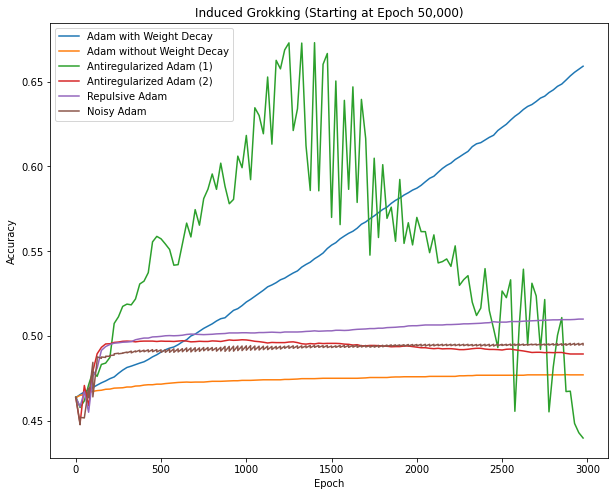

In [ ]:
ax = (df_full.loc[df_full["model"] == "Adam_WD"]).plot("epoch", "acc_test", label="Adam with Weight Decay", )
(df_full.loc[df_full["model"] == "Adam"]).plot("epoch", "acc_test", label="Adam without Weight Decay", ax=ax)
(df_full.loc[df_full["model"] == "AdamSphere_2"]).plot("epoch", "acc_test", label="Antiregularized Adam (1)", ax=ax)
(df_full.loc[df_full["model"] == "AdamSphere_1"]).plot("epoch", "acc_test", label="Antiregularized Adam (2)", ax=ax)
(df_full.loc[df_full["model"] == "AdamRepulsive_0"]).plot("epoch", "acc_test", label="Repulsive Adam", ax=ax)
(df_full.loc[df_full["model"] == "AdamNoise_1"]).plot("epoch", "acc_test", label="Noisy Adam", ax=ax)

plt.title("Induced Grokking (Starting at Epoch 50,000)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

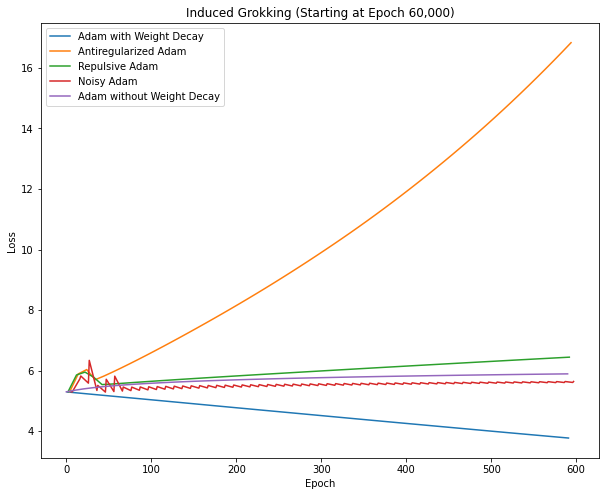

In [ ]:
(df_full.loc[df_full["model"] == "Adam_WD"]["L_test"]).plot(label="Adam with Weight Decay")
(df_full.loc[df_full["model"] == "AdamSphere_2"]["L_test"]).plot(label="Antiregularized Adam")
(df_full.loc[df_full["model"] == "AdamSphere_0"]["L_test"]).plot(label="Repulsive Adam")
(df_full.loc[df_full["model"] == "AdamNoise_1"]["L_test"]).plot(label="Noisy Adam")
(df_full.loc[df_full["model"] == "Adam"]["L_test"]).plot(label="Adam without Weight Decay")


plt.title("Induced Grokking (Starting at Epoch 60,000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()